# Airport Queueing Simulation

# Simulation Code Implementation

In [169]:
import scipy.stats as sts
from scipy.stats import truncnorm, expon
import random
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Source code: (Scheffler, 2020)
import heapq
class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implements an event schedule using a priority queue, allowing events to be added
    and run in chronological order. The `now` attribute contains the time at which
    the last event was run.
    
    Attributes:
        now (int or float): Represents the current time in the schedule.
        priority_queue (list): A heap queue to store events in chronological order.
    '''
    
    def __init__(self):
        '''
        Initializes a new instance of the Schedule with no events.
        '''
        self.now = 0 
        self.priority_queue = []
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        '''
        Adds an event to the schedule at a specific point in time.
        
        Args:
            timestamp (int or float): The time at which the event is scheduled to run.
            function (callable): The function to execute when the event runs.
            *args: Variable positional arguments to pass to the function.
            **kwargs: Variable keyword arguments to pass to the function.
        '''
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        '''
        Schedules an event to run after a specified time interval.
        
        Args:
            interval (int or float): The time interval after which the event is scheduled to run.
            function (callable): The function to execute when the event runs.
            *args: Variable positional arguments to pass to the function.
            **kwargs: Variable keyword arguments to pass to the function.
        '''
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        '''
        Returns the timestamp of the next event in the schedule.
        
        Returns:
            int or float: The timestamp of the next event.
        '''
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        '''
        Retrieves the next event from the priority queue and executes it, updating the `now` attribute
        to the timestamp of this event.
        '''
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)

In [6]:
# Source Code: (Minerva University, 2023)
class Queue:
    """
    Represents a Queue in an airport
    
    Attributes:
        service_distribution: The service time distribution for people in the queue.
        additional_screening_dist: The distribution for additional screening times.
        num (int): The queue number or identifier.
        p_security_officer (float): The probability of requiring additional security screening.
        people_in_queue (int): The number of people currently in the queue.
        people_being_served (int): The number of people currently being served.
        people_in_additional_screening (int): The number of people undergoing additional screening.
        arrival_times (list): A list of arrival times of people in the queue.
        waiting_times (list): A list of waiting times of people in the queue.
    """
    def __init__(self, service_distribution, additional_screening_dist, num, p_security_officer):
        """
        Initializes a new instance of a Queue class.
        """
        self.p_security_officer = p_security_officer
        self.num = num
        self.service_distribution = service_distribution
        self.people_in_queue = 0
        self.people_being_served = 0
        self.people_in_additional_screening = 0
        self.arrival_times = []
        self.waiting_times = []
    
    def reset(self):
        """
        Resets the queue attributes to handle a new set of people.
        """
        self.people_in_queue = 0
        self.people_being_served = 0
        self.people_in_additional_screening = 0
        self.arrival_times = []
        self.waiting_times = []
    
    def length(self):
        """
        Returns:
            int: The number of people currently in the queue.
        """
        return self.people_in_queue

    def add_person(self, schedule):
        """
        Adds a person to the queue and schedules immediate service if available.
        
        Args:
            schedule (Schedule): The event schedule to which the serving event is added.
        """
        self.people_in_queue += 1
        self.arrival_times.append(schedule.now) # to track the waiting time
        if self.people_being_served < 1:
            # Serving the added person immediately
            schedule.add_event_after(0, self.start_serving_person)
            
    def start_serving_person(self, schedule):
        """
        Starts serving a person from the queue and schedules the finish event.
        
        Args:
            schedule (Schedule): The event schedule to which the finish event is added.
        """
        
        # Moving a person from a queue to a server
        self.people_in_queue -= 1
        self.people_being_served += 1
        arrival_time = self.arrival_times.pop(0)
        waiting_time = schedule.now - arrival_time
        self.waiting_times.append(waiting_time)
        
        # Scheduling when the server will have processed the traveler
        # Checking for additional screening
        if random.random() < self.p_security_officer:
            self.people_in_additional_screening += 1
            schedule.add_event_after(
                additional_screening_dist.rvs(),
                self.finish_additional_screening) 
        else:
            schedule.add_event_after(
                self.service_distribution.rvs(),
                self.finish_serving_person)
            
    def finish_serving_person(self, schedule):
        """
        Finishes serving a person and starts serving the next person
        
        Args:
            schedule (Schedule): The event schedule to which the new serving event may be added.
        """
        # Removing the person from a server station
        self.people_being_served -= 1
        # Serving the next person if there are still people in the queue
        # and nobody is being screned by senior officer
        if self.people_in_queue > 0 and self.people_in_additional_screening < 1:
            schedule.add_event_after(0, self.start_serving_person)
    
    def finish_additional_screening(self, schedule):
        """
        Finishes the additional screening for a person and starts serving the next person
        
        Args:
            schedule (Schedule): The event schedule to which the new serving event can be added
        """
        # Removing a person from the additional screening
        self.people_in_additional_screening -= 1  
        if self.people_in_queue > 0:
            schedule.add_event_after(0, self.start_serving_person)


class Airport:
    """
    Represents an Airport with multiple queues
    
    Attributes:
        queues (list): A list of Queue instances representing separate queues in the airport
        arrival_distribution: The distribution of arrival times of people to the airport
    """
    
    def __init__(self, n_queues, 
                 arrival_distribution, 
                 service_distribution, 
                additional_screening_dist,
                p_security_officer):
        """
        Initializes the airport with a specified number of queues and arrival distribution
        """
        self.queues = [Queue(service_distribution, additional_screening_dist, n, p_security_officer) for n in range(n_queues)]
        self.arrival_distribution = arrival_distribution
    
    def reset(self):
        """
        Resets all the queues in the airport before processing a new group of people in the next trial
        """
        for queue in self.queues:
            queue.reset()

    def add_person(self, schedule):
        """
        Adds a person to the shortest queue in the airport and schedules the arrival of the next person
        
        Args:
            schedule (Schedule): The event schedule to which the arrival event is added
        """
        # choosing the shortest queue based on queue length
        shortest_queue = min(self.queues, key=lambda q: q.length())
        shortest_queue.add_person(schedule)
        # Schedule when to add another person according to arrival distribution
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_person)

    def run(self, schedule):
        """
        Resets the airport and schedules the arrival of the first person
        
        Args:
            schedule (Schedule): The event schedule to which the first arrival event is added
        """
        self.reset()
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_person)

## Running the experiment

In [9]:
mu = 1/2
sigma = 1/6
a = (0 - mu) / sigma
b = float('inf') 
num_trials = 200
run_until = 1000
service_distribution = truncnorm(a=a, b=b, loc=mu, scale=sigma)
additional_screening_dist = truncnorm(a=(0-2)/2, b=float('inf'), loc=2, scale=2)
arrival_rate = 10
arrival_distribution = sts.expon(scale=1 / arrival_rate)

def run_experiment(num_queues, trials=num_trials, simulation_time=run_until, 
                   service_distribution = service_distribution, 
                   arrival_distribution = arrival_distribution,
                  additional_screening = additional_screening_dist, 
                  p_security_officer = 0.05):
    """
    Run the simulation for a specified number of trials, returns the average waiting times, 
    average queue lengths, and maximum queue lengths over all the trials.
    
    Args:
        num_queues (int): The number of queues in the airport
        trials (int, optional): The number of simulation trials to run. Defaults to `num_trials`
        simulation_time (float, optional): The total time to run each simulation. Defaults to `run_until`
        service_distribution: The service time distribution for people in the queue
        arrival_distribution: The distribution of arrival times of people to the airport
        additional_screening: The distribution for additional screening times
        p_security_officer (float, optional): The probability of a person requiring additional security screening. Defaults to 0.05
    
    Returns:
        tuple: containing three lists:
            - avg_waiting_times (list): The average waiting times per person over all trials
            - avg_queue (list): The average queue lengths per event over all trials
            - max_over_trials (list): The maximum queue lengths over all trials
    """

    avg_waiting_times = []
    avg_queue = []
    max_over_trials = []
    
    for trial in range(trials):
        schedule = Schedule()
        airport = Airport(num_queues, arrival_distribution, 
                          service_distribution, additional_screening, 
                          p_security_officer)
        
        queue_lengths = []
        airport.run(schedule) 
        total_queue_length = 0
        total_waiting_time = 0
        current_max = 0
        
        while schedule.now < simulation_time:
            schedule.run_next_event()
            # summing total queue length over all the queues
            total_length = sum(queue.length() for queue in airport.queues)
            queue_lengths.append(total_length)
            # only saving the maximum length in each trial
            max_queue = max(airport.queues, key=lambda q: q.length())
            current_max = max(current_max, max_queue.length())
        
        max_over_trials.append(current_max)
        # getting the average queue length per event each trial
        avg_length = sum(queue_lengths)/len(queue_lengths)
        avg_queue.append(avg_length)
        avg_waiting_time = sum(sum(queue.waiting_times) for queue in airport.queues) / sum(len(queue.waiting_times) for queue in airport.queues)  # per person
        avg_waiting_times.append(avg_waiting_time)
    
    return avg_waiting_times, avg_queue, max_over_trials


# Test cases and theoretical analysis

## Theoretical calculations with 1 queue without a senior officer

In [118]:
def average_waiting_time(n_queues, service_time, variance, arrival_rate):
    """
    Calculate the theoretical expected average waiting time using the M/G/1 formula
    
    Args:
        n_queues (int): The number of queues in the system.
        service_time (float): The average service time per person.
        variance (float): The variance of the service time.
        arrival_rate (float): The overall arrival rate of people to the queues.
        
    Returns:
        float: The theoretical expected average waiting time per person in the system.
        
    Formula:
        Given ρ (utilisation) = (arrival rate per queue) * service_time
        E(W) = ((ρ * service_time) / (2 * (1 - ρ))) * (1 + (variance / (service_time)^2))
    """
    queue_arrival_rate = arrival_rate / n_queues
    rho = service_time * queue_arrival_rate
    if rho < 1:
        first_part = (rho * service_time)/(2*(1-rho))
        second_part = 1 + variance/((service_time)**2)
        waiting_time = first_part * second_part
    else:
        waiting_time = float("inf")
    return waiting_time
    
def average_queue_length(n_queues, service_time, variance, arrival_rate):
    """
    Calculate the theoretical expected average queue length using the M/G/1 formula
    
    Args:
        n_queues (int): The number of queues in the system.
        service_time (float): The average service time per person.
        variance (float): The variance of the service time.
        arrival_rate (float): The overall arrival rate of people to the queues.
        
    Returns:
        float: The theoretical expected average queue length in the system
        
    Formula:
        L = (arrival rate per queue) * E(W)
        where E(W) is the expected average waiting time per person
    """
    queue_arrival_rate = arrival_rate / n_queues
    waiting_t = average_waiting_time(n_queues, service_time, variance, arrival_rate)
    if waiting_t == float("inf"):
        average_queue_len = float("inf")
    else: 
        average_queue_len = queue_arrival_rate * average_waiting_time(n_queues, service_time, variance, arrival_rate)
    return average_queue_len

#average_waiting_time(n_queues, service_time, variance, arrival_rate), average_queue_length(n_queues, service_time, variance, arrival_rate)

## Test case: theoretical exapected values comparison with simulated values for various arrival rates, 1 service station and no security officer

In [157]:
def getting_stats_arrivals(run_until, num_trials, p_check, 
                           rates, service_distribution, 
                           additional_screening_dist, n_queues = 1):
    """
    Runs the simulation for various arrival rates and gather statistics on 
    waiting times, queue lengths, and maximum queue lengths
    
    Args:
        run_until (float): The simulation time for each trial.
        num_trials (int): The number of trials to run the experiment.
        p_check (float): The probability of security check.
        rates (list): A list of arrival rates to run the simulation.
        service_distribution: The service time distribution for people in the queue
        additional_screening_dist: The distribution for additional screening times
        n_queues (int, optional): The number of queues in the system. Defaults to 1.
        
    Returns:
        tuple: A tuple containing lists of means and standard errors for
               maximum queue lengths, waiting times, and average queue lengths
               for each arrival rate.
               
        - max_queue_means (list): The mean of maximum queue lengths for each arrival rate.
        - max_queue_st (list): The standard error of maximum queue lengths for each arrival rate.
        - waiting_times_means (list): The mean of waiting times for each arrival rate.
        - waiting_time_st (list): The standard error of waiting times for each arrival rate.
        - queue_length_means (list): The mean of average queue lengths for each arrival rate.
        - queue_length_st (list): The standard error of average queue lengths for each arrival rate.
    
    Note:
        The function uses run_experiment to run the simulation for each arrival rate and 
        gathers statistics on the maximum queue lengths, waiting times, and average queue lengths.
    """
    waiting_times_means, queue_length_means, max_queue_means = [], [], []
    waiting_time_st, queue_length_st, max_queue_st = [], [], []

    for r in rates: 
        arrival_distribution = sts.expon(scale=1 / r)
        waiting_time, queue_len, max_queue = run_experiment(n_queues, trials=num_trials, simulation_time=run_until1, 
                                              service_distribution = service_distribution, 
                                              arrival_distribution = arrival_distribution, 
                                              additional_screening = additional_screening_dist, p_security_officer = p_check)
        waiting_time_st.append(sts.sem(waiting_time))
        queue_length_st.append(sts.sem(queue_len))
        max_queue_st.append(sts.sem(max_queue))
        max_queue_means.append(np.mean(max_queue))
        waiting_times_means.append(np.mean(waiting_time))
        queue_length_means.append(np.mean(queue_len))
    
    return max_queue_means, max_queue_st, waiting_times_means, waiting_time_st, queue_length_means, queue_length_st

In [158]:
# Getting and storing the statistics from the "getting_stats_arrivals" function above
mu = 1/2
sigma = 1/6
service_distribution = truncnorm(a=(0 - mu) / sigma, b=float('inf') , loc=mu, scale=sigma)
additional_screening_dist = truncnorm(a=(0-2)/2, b=float('inf'), loc=2, scale=2)
run_until = 1000 # changed to 1000
num_trials = 200
p_check = 0 # no security officer
rates = np.linspace(0.1, 1.9, 5) # arrival rates ranging from 0.5 to 1.9, to keep rho < 1

basic_max_means, basic_max_st, basic_wait_means, basic_wait_st, basic_len_means, basic_len_st = getting_stats_arrivals(run_until, num_trials, p_check, rates,service_distribution, additional_screening_dist, n_queues = 1)

In [159]:
n_queues, service_time, variance = 1, 0.5, (1/6)**2
waiting_times_theory_arrivals = []
queue_len_theory_arrivals = []
rates = np.linspace(0.1, 1.9, 5) # arrival rates

# Making and storing theoretical calculations for every arrival rate in rates list
for r in rates:
    waiting_times_theory_arrivals.append(average_waiting_time(n_queues, service_time, variance, r))
    queue_len_theory_arrivals.append(average_queue_length(n_queues, service_time, variance, r))

The code block below creates a visualisation comparing theoretical and simulated values for average queue length and individual waiting time. Firstly, I calculate the 95% confidence intervals (error bars) using the simulated values stored above for both average queue length and waiting time. Then, I plot the two plots side by side.

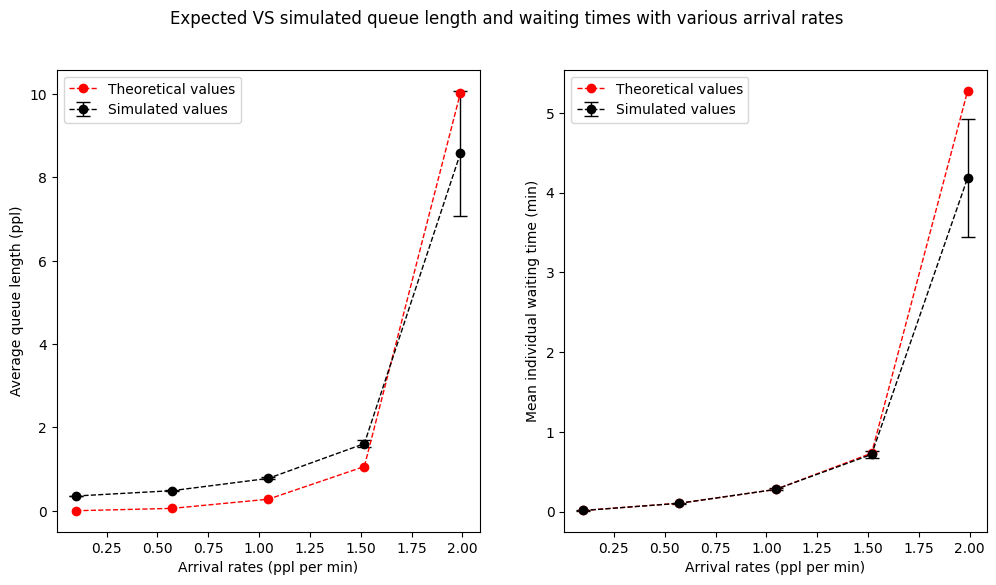

In [165]:
error_bars_len, error_bars_wait = [], []

# Calculating the error bars/confidence intervals for simulated queue average
for len_mean, len_st in zip(basic_len_means, basic_len_st):
    error_bars_len.append((len_mean + 1.96*len_st) - (len_mean - 1.96*len_st))

# Calculating the error bars/ Confidence intervals for simulated waiting time average
for wait_mean, wait_st in zip(basic_wait_means, basic_wait_st):
    error_bars_wait.append((wait_mean + 1.96*wait_st) - (wait_mean - 1.96*wait_st))

# Plotting the Expected VS Simulated values on subplots side by side
fig, axs = plt.subplots(1, 2, figsize = (12, 6)) 
x_axis = np.linspace(0.1, 1.99, 5)


axs[0].errorbar(x_axis, basic_len_means, 
    yerr = error_bars_len, color='black', 
    marker='o', capsize=5, linestyle='--', linewidth=1, 
    label = "Simulated values")

axs[0].plot(x_axis, queue_len_theory_arrivals,
        color='red', marker='o', linestyle='--', linewidth=1,
        label='Theoretical values')
axs[0].set_xlabel("Arrival rates (ppl per min)")
axs[0].set_ylabel("Average queue length (ppl)")
axs[0].legend(loc = "upper left")

axs[1].errorbar(x_axis, basic_wait_means, 
    yerr = error_bars_wait, color='black', 
    marker='o', capsize=5, linestyle='--', linewidth=1, 
    label = "Simulated values")

axs[1].plot(x_axis, waiting_times_theory_arrivals,
        color='red', marker='o', linestyle='--', linewidth=1,
        label='Theoretical values')
axs[1].set_xlabel('Arrival rates (ppl per min)')
axs[1].set_ylabel('Mean individual waiting time (min)')
axs[1].legend(loc = "upper left")

fig.suptitle("Expected VS simulated queue length and waiting times with various arrival rates")
plt.show()

**About the parameters and system:** <br>
The simulated values on the plots above were achieved by running the simulation with the following parameters: <br><br> - run_until (dictates how long the simulation should run for on a given trial) = 5000 minutes; <br> - num_trials = 200; <br> - p = 0, and "rates" (dictates the arrival rates) ranging from 0.5 to 1.9. <br><br> Run_until parameter was chosen to ensure the simulation achieves equilibrium so that a meaningful comparison to the theoretical values can be made. The number of trials was chosen to reduce variability of the results, construct meaningful confidence intervals and ensure the results conform to the Law of Large Numbers to make an insightful comparison between the expected and simulated values. The probability of security officer check was set to 0 and the number of queue to 1 to see if the simulation produces reasonable results at a basic level before making predictions for how the simulation should behave with multiple queues and security officer. The arrival rates were chosen to range from 0.5 to 1.9, while service time was held constant at 0.5 minutes. This was done to prevent $\rho$ from becoming more than 1. $\rho$ measures the utilisation of the system, $\rho = \frac{\lambda}{\mu}$. This means that if $\rho$ is greater than 1, the system will be unstable because the arrival rate is equal to or greater than the service rate causing infinite queue lengths and waiting times. 

**Comparison of the values/Analysis** <br>
The plots show that the simulated and theoretical values correspond closely. On the first subplot, simulated values for the average queue length with 0.5 - 1.7 arrival rates differ by 0.5-1 person from the expected values. This can be due to statistical or rounding error. However, we see that when arrival rate reaches 1.9 people per minute, the values match up. The confidence interval at arrival rate 1.9 is much larger than that for other values, however, it is expected since the system is moving towards an unstable state where $\rho$ reaches 1 and variability increases. On the second subplot we see that the simulated and expected mean waiting times match up very closely up until arrival rate 1.9 (ppl per min) where we see a discrepency of ~ 0.5 min. However, the expected waiting time at this arrival rate is within the simulated confidence interval, meaning that the observed results are in line with the expected value. <br><br> Hence, since there is no big discrepency between the expected and observed results, the simulation is implemented correctly at a basic level (with no senior officer and one queue) since the statistics it produces correspond to the theoretical values. This comparison can be used as a test case, since we see that the simulation runs as expected with reasonable results.

### Maximum Queue length

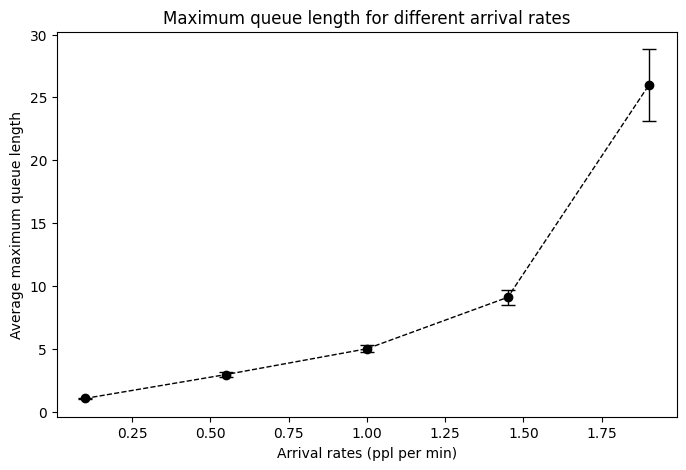

In [163]:
error_bars_max = []

# Calculating the error bars/ Confidence intervals for simulated queue length
for mean, st in zip(basic_max_means, basic_max_st):
    error_bars_max.append((mean + 1.96*st) - (mean - 1.96*st))
x_axis = np.linspace(0.1, 1.9, 5)

plt.figure(figsize = (8, 5))
plt.errorbar(x_axis, basic_max_means, 
    yerr = error_bars_max, color='black', 
    marker='o', capsize=5, linestyle='--', linewidth=1)
plt.xlabel('Arrival rates (ppl per min)')
plt.ylabel('Average maximum queue length')
plt.title("Maximum queue length for different arrival rates")
plt.show()

The plot above showcases the maximum queue length at different arroval rates. While I am not comparing the simulated results to the expected results, one can see that the maximum values correspond to the average values and show the same trend. Moreover, the maximum values are approximately 3x times larger than the average values reported above. Hence, the results align with one another.

## Test case: theoretical expected values comparison with simulated values for multiple service stations and no security officer

In [114]:
def getting_stats_nqueues(num_queues, run_until, num_trials, p_check, 
                          service_distribution, arrival_distribution, 
                         additional_screening_dist):
    """
    Runs simulations with varying number of queues/service stations and
    gathers statistics on average queue length, waiting time, and 
    maximum queue length.
    
    Args:
        num_queues (int): The number of queues/service stations to simulate.
        run_until (float): The simulation time for each trial.
        num_trials (int): The number of trials to run the experiment.
        p_check (float): The probability parameter for the security officer check in the `run_experiment` function.
        service_distribution: The service time distribution for people in the queue.
        arrival_distribution: The arrival time distribution.
        additional_screening_dist: The additional screening distribution.

    Returns:
        tuple: A tuple containing lists of means and standard errors for maximum queue lengths, waiting times, and average queue lengths for each number of queues.
            - max_queue_means (list): The mean of maximum queue lengths for each number of queues.
            - max_queue_st (list): The standard error of maximum queue lengths for each number of queues.
            - waiting_times_means (list): The mean of waiting times for each number of queues.
            - waiting_time_st (list): The standard error of waiting times for each number of queues.
            - queue_length_means (list): The mean of average queue lengths for each number of queues.
            - queue_length_st (list): The standard error of average queue lengths for each number of queues.
    """
    waiting_times_means, queue_length_means, max_queue_means = [], [], []
    waiting_time_st, queue_length_st, max_queue_st = [], [], []

    for i in range(1, num_queues+1):
        waiting_time, queue_len, max_queue = run_experiment(i, trials=num_trials, simulation_time=run_until, 
                                              service_distribution = service_distribution, 
                                              arrival_distribution = arrival_distribution, 
                                              additional_screening = additional_screening_dist, p_security_officer = p_check)
        waiting_time_st.append(sts.sem(waiting_time))
        queue_length_st.append(sts.sem(queue_len))
        max_queue_st.append(sts.sem(max_queue))
        max_queue_means.append(np.mean(max_queue))
        waiting_times_means.append(np.mean(waiting_time))
        queue_length_means.append(np.mean(queue_len))
    
    return max_queue_means, max_queue_st, waiting_times_means, waiting_time_st, queue_length_means, queue_length_st

In [115]:
# Getting and storing statistics for queue length and waiting time for multiple service stations
# using the getting_stats_nqueues() function above
mu = 1/2
sigma = 1/6
arrival_rate = 10
service_distribution = truncnorm(a=(0 - mu) / sigma, b=float('inf') , loc=mu, scale=sigma)
additional_screening_dist = truncnorm(a=(0-2)/2, b=float('inf'), loc=2, scale=2)
arrival_distribution = sts.expon(scale=1 / arrival_rate)
num_queues = 11
run_until1 = 500
num_trials = 100
p_check = 0

n_stations_max, n_stations_max_st, n_stations_wait, n_stations_wait_st, n_stations_len, n_stations_len_st = getting_stats_nqueues(num_queues, run_until, num_trials, p_check, 
                                                                                                                                     service_distribution, arrival_distribution, 
                                                                                                                                     additional_screening_dist)

The code cell below uses the functions defined above to get the theoretical values for the model with multiple queues.

In [119]:
n_queues, service_time, variance = 11, 0.5, (1/6)**2
waiting_times_theory_queues = []
queue_len_theory_queues = []
arrival_rate = 10

# Making and storing theoretical calculations for every different numbers of service stations
for n in range(1, num_queues):
    waiting_times_theory_queues.append(average_waiting_time(n, service_time, variance, arrival_rate))
    queue_len_theory_queues.append(average_queue_length(n, service_time, variance, arrival_rate))

The code block below creates a visualisation comparing theoretical and simulated values for average queue length and individual waiting time. Firstly, I calculate the 95% confidence intervals (error bars) using the simulated values stored above for both average queue length and waiting time. Then, I plot the two plots side by side. It should be noted that since I am not changing the arrival or service rates, $\rho$ value is greater than 1 for less than 5 queues. This means that below 5 queues, the system is unstable and the queue length and wating times will be reaching infinity. Hence, I did not plot theoretical values for less than 5 queues, since they would be "inf".

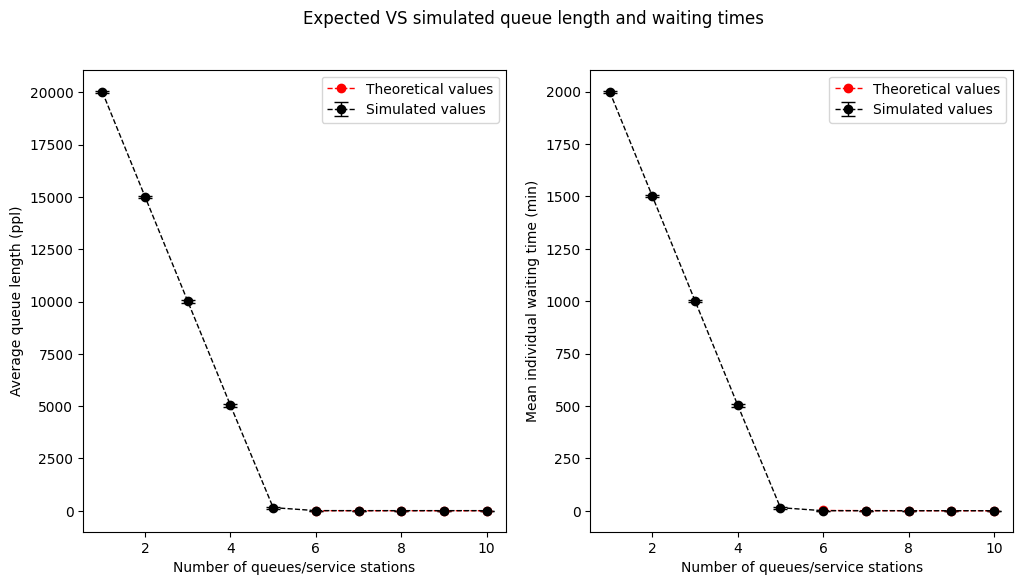

In [129]:
error_bars_len_qs, error_bars_wait_qs = [], []

# Calculating the error bars/ Confidence intervals for simulated queue length
for len_mean, len_st in zip(n_stations_len, n_stations_len_st):
    error_bars_len_qs.append((len_mean + 1.96*len_st) - (len_mean - 1.96*len_st))

# Calculating the error bars/ Confidence intervals for simulated waiting time average
for wait_mean, wait_st in zip(n_stations_wait, n_stations_wait_st):
    error_bars_wait_qs.append((wait_mean + 1.96*wait_st) - (wait_mean - 1.96*wait_st))

# Plotting the Expected VS Simulated values on subplots side by side
fig, axs = plt.subplots(1, 2, figsize = (12, 6)) 
x_axis = np.linspace(1, 10, 10)


axs[0].errorbar(x_axis, n_stations_len, 
    yerr = error_bars_len_qs, color='black', 
    marker='o', capsize=5, linestyle='--', linewidth=1, 
    label = "Simulated values")

# Only plotting the theoretical values for 5+ queues
# because the first 5 are "inf"
axs[0].plot(x_axis[5:], queue_len_theory_queues[5:],
        color='red', marker='o', linestyle='--', linewidth=1,
        label='Theoretical values')
axs[0].set_xlabel("Number of queues/service stations")
axs[0].set_ylabel("Average queue length (ppl)")
axs[0].legend(loc = "upper right")

axs[1].errorbar(x_axis, n_stations_wait, 
    yerr = error_bars_wait_qs, color='black', 
    marker='o', capsize=5, linestyle='--', linewidth=1, 
    label = "Simulated values")

# Only plotting the theoretical values for 5+ queues
# because the first 5 are "inf"
axs[1].plot(x_axis[5:], waiting_times_theory_queues[5:],
        color='red', marker='o', linestyle='--', linewidth=1,
        label='Theoretical values')
axs[1].set_xlabel('Number of queues/service stations')
axs[1].set_ylabel('Mean individual waiting time (min)')
axs[1].legend(loc = "upper right")

fig.suptitle("Expected VS simulated queue length and waiting times")
plt.show()


**About the parameters and system:** <br>
The simulated values on the plots above were achieved by running the simulation with the following parameters: <br><br> - run_until (dictates how long the simulation should run for on a given trial) = 500 minutes; <br> - num_trials = 50; <br> - p = 0; <br> The arrival, service and additional check distributions were kept the same as in the problem description to observe the effect of multiple queues on the simulated model and to compare with the theoretical values. <br><br>
Similarly to the test case with multiple arrival rates above, run_until parameter was chosen to ensure the simulation achieves equilibrium so that a meaningful comparison to the theoretical values can be made. The number of trials was chosen to reduce variability of the results, construct meaningful confidence intervals and ensure the results conform to the Law of Large Numbers to make an insightful comparison between the expected and simulated values. The probability of security officer check was set to 0 to see if the simulation produces reasonable results at a more basic level before making predictions for how the simulation should behave with a security officer. As mentioned in the description before the code block, keeping the arrival and service distributions the same as in the problem description means that $\rho$ is going to be greater than 1 for certain scenarios. Since we are looking at per queue arrival rates, $\rho$ is less than 1 when the number of queues > 5. This is why the plots above do not have values for when n_queues < 5. The queue length and waiting times are then increasing infinitely, which hinders any meaningful comparisons. Therefore, theoretical results associated with scenarios with n_queues > 5 were shown.

**Comparison of the values/Analysis** <br>
We can see that after n_queues reaches more than 5 queues, the theoretical and simulated values match up very closely. This means that the implemented simulated model accurately represents the theoretical model at a basic level (without the senior officer). The fact that the model and simulation agree makes sense because we have already shown that the models agree with only one queue and no senior officer above. This test simply adds one complication, - more queues. Theoretically, this simply requires us to compute "per queue" metrics to derive meaningful results. This comparison can be used as a test case for the simulation model. The model produces the expected results and, hence, passes the test cases. 

### Maximum queue length

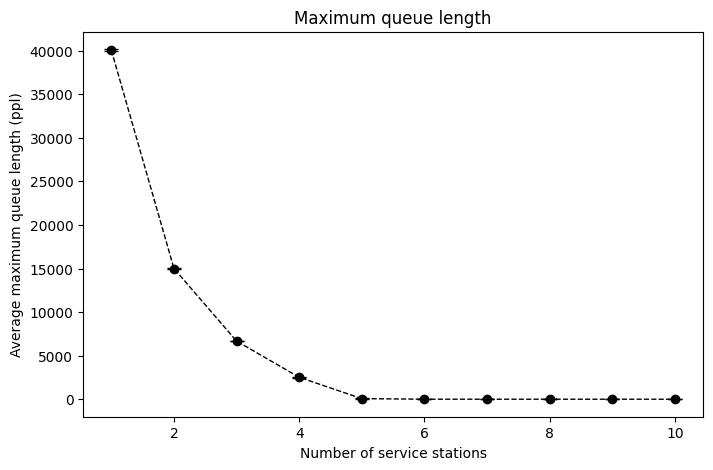

In [166]:
error_bars_max_qs = []

# Calculating the error bars/ Confidence intervals for simulated queue length
for mean, st in zip(n_stations_max, n_stations_max_st):
    error_bars_max_qs.append((mean + 1.96*st) - (mean - 1.96*st))
x_axis = np.linspace(1, 10, 10)

plt.figure(figsize = (8, 5))
plt.errorbar(x_axis, n_stations_max, 
    yerr = error_bars_max_qs, color='black', 
    marker='o', capsize=5, linestyle='--', linewidth=1)
plt.xlabel('Number of service stations')
plt.ylabel('Average maximum queue length (ppl)')
plt.title("Maximum queue length")
plt.show()

The above plot shows only simulated values for the maximum queue length which correponds to the trend seen on the plots above and suggests that the simulated model was implemented correctly.

# Theoretical Calculations for multiple queues with a senior officer

In [142]:
def theoretical_vals_security_officer(n_queues, service_time, 
                                      variance, arrival_rate, 
                                      prob_check, service_time_extra,
                                     variance_extra):
    """
    Calculate the theoretical average queue length and waiting time 
    with the addition of a senior security officer. The function 
    takes into account the possibility of an additional security check 
    and computes effective service rate and variance based on the 
    given parameters.

    Parameters
    ----------
    n_queues : int
        The number of queues in the system.
    service_time : float
        The average service time per individual.
    variance : float
        The variance in service time.
    arrival_rate : float
        The rate at which individuals arrive at the queues.
    prob_check : float
        The probability of an additional security check by the 
        senior officer.
    service_time_extra : float
        The average service time for the additional security check.
    variance_extra : float
        The variance in service time for the additional security check.

    Returns
    -------
    mean_queue_length : list of float
        A list containing the average queue lengths for each queue in 
        the system, considering up to `n_queues` queues.
    mean_waiting_time : list of float
        A list containing the average waiting times in the queue for 
        each queue in the system, considering up to `n_queues` queues.
    """
    # Incorporating the probability of an additional check into the service rate and variance
    effective_service_rate = 1/(service_time + prob_check* service_time_extra)
    effective_variance = variance + prob_check * variance_extra
    mean_queue_length = []
    mean_waiting_time = []

    
    for n in range(1, n_queues + 1):
        queue_arrival_rate = arrival_rate / n
        rho = (queue_arrival_rate/effective_service_rate)
        
        # Only calculating the metrics for when rho < 1 bc otherwise the system is unstable
        if rho < 1:
            length = (queue_arrival_rate * (1/effective_service_rate) + (queue_arrival_rate**2 * effective_variance) / 2) / (1 - (queue_arrival_rate/effective_service_rate))
            waiting_time = length/queue_arrival_rate
            mean_queue_length.append(length)
            mean_waiting_time.append(waiting_time)
        
        # If Rho is >= 1, the queue length and waiting times will be reaching infinity
        else:
            mean_queue_length.append(float("inf"))
            mean_waiting_time.append(float("inf"))

    return mean_queue_length, mean_waiting_time

In [144]:
# Calculating and storing theoretical values for queue simulation with a senior officer
n_queues, service_time, variance, arrival_rate, prob_check, service_time_extra, variance_extra = 10, 0.5, (1/6)**2, 10, 0.05, 2, 2**2
senior_theoretical_len_mean, senior_theoretical_wait_mean = theoretical_vals_security_officer(n_queues, service_time, 
                                                                                              variance, arrival_rate, 
                                                                                              prob_check, service_time_extra,
                                                                                              variance_extra)

## Test case: theoretical values comparison with the simulated values (multiple queues & senior officer)

In [140]:
# Getting and storing simulated statistics for multiple queues and a senior officer
num_queues, run_until = 11, 500
num_trials, p_check = 300, 0.05
mu = 1/2
sigma = 1/6
arrival_rate = 10
service_distribution = truncnorm(a=(0 - mu) / sigma, b=float('inf') , loc=mu, scale=sigma)
additional_screening_dist = truncnorm(a=(0-2)/2, b=float('inf'), loc=2, scale=2)
arrival_distribution = sts.expon(scale=1 / arrival_rate)

senior_max_means, senior_max_st, senior_wait_means, senior_wait_st, senior_len_means, senior_len_st = getting_stats_nqueues(num_queues, run_until, num_trials, p_check, service_distribution, arrival_distribution, additional_screening_dist)


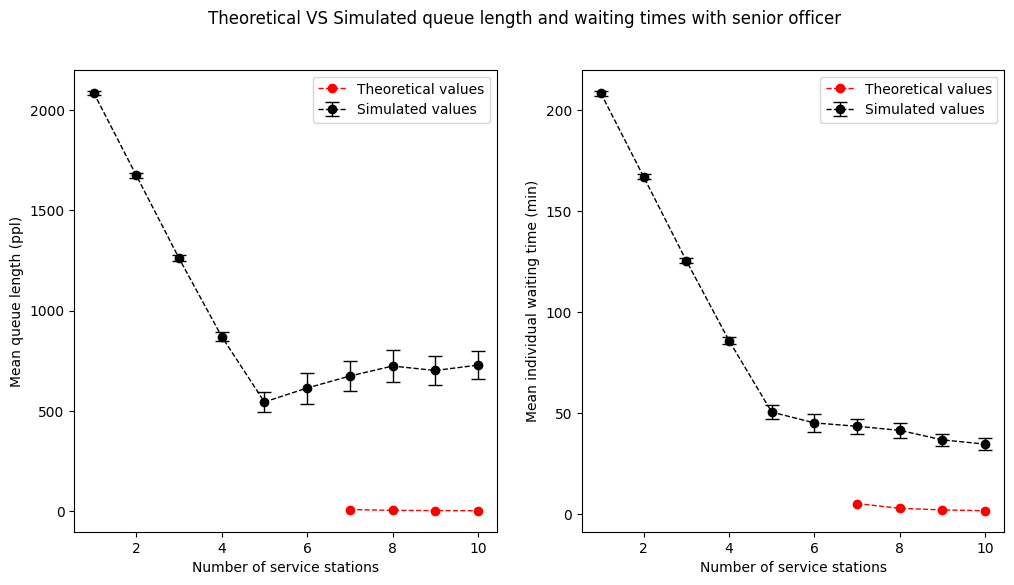

In [167]:
error_bars_senior_length, error_bars_senior_wait = [], []

# Plotting the Expected VS Simulated values on subplots side by side
fig, axs = plt.subplots(1, 2, figsize = (12, 6)) 
x_axis = np.linspace(1, 10, 10)

# Calculating the error bars/ Confidence intervals for simulated queue length
for m, s in zip(senior_len_means, senior_len_st):
    error_bars_senior_length.append((m + 1.96*s) - (m - 1.96*s))

# Calculating the error bars/ Confidence intervals for simulated waiting time average
for wait_mean, wait_st in zip(senior_wait_means, senior_wait_st):
    error_bars_senior_wait.append((wait_mean + 1.96*wait_st) - (wait_mean - 1.96*wait_st))

axs[0].errorbar(x_axis, senior_len_means, 
    yerr = error_bars_senior_length, color='black', 
    marker='o', capsize=5, linestyle='--', linewidth=1, 
    label = "Simulated values")
axs[0].plot(x_axis[6:], senior_theoretical_len_mean[6:],
        color='red', marker='o', linestyle='--', linewidth=1,
        label='Theoretical values')
axs[0].legend(loc = "upper right")

axs[0].set_xlabel('Number of service stations')
axs[0].set_ylabel('Mean queue length (ppl)')

axs[1].errorbar(x_axis, senior_wait_means, 
    yerr = error_bars_senior_wait, color='black', 
    marker='o', capsize=5, linestyle='--', linewidth=1, 
    label = "Simulated values")
axs[1].plot(x_axis[6:], senior_theoretical_wait_mean[6:],
        color='red', marker='o', linestyle='--', linewidth=1,
        label='Theoretical values')
axs[1].legend(loc = "upper right")

axs[1].set_xlabel('Number of service stations')
axs[1].set_ylabel('Mean individual waiting time (min)')

fig.suptitle("Theoretical VS Simulated queue length and waiting times with senior officer")
plt.show()

There is an obvious discrepency between the expected and simulated values, which is elaborated on in the report. However, it is worth noting that this is due to the assumptioms made by the theoretical model about the availability of the senior security officer. Since the simulation ony has one senior security officer, travelers have to wait until they can undergo the additional screening, while the theoretical model assumes that the senior security officer is available as soon as needed. The theoretical values included are only starting models with the number of service stations > 6, due to the $\rho$ being >= 1 prior to that point.